# Modelling notebook - ModelABC

This notebook contains two main sections:

1. Training models - Defines Models A,B and C and trains them
2. Evaluating models on 'Test' data - Evaluates Models A,B and C on the test data

In [7]:
#If using saturn cloud, downgrade numpy
#pip install -U numpy==1.18.5

In [1]:
# Custom functions and setup

from functions_auto import *
import config

# Other packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Tensorflow

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import Sequence, plot_model

2022-04-27 12:50:19.851802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Setting seed
tf.random.set_seed(123)
np.random.seed(123)

In [1]:
#### Download GloveEmbeddings

# - The following code chunk can be used to download the word embeddings, and extracts the correct file from the zip
# - Is included in gitignore so will be kept on your computer

#import urllib.request
#import shutil
#import zipfile
#urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
#shutil.move(config.base_dir+'glove.6B.zip', config.base_dir+'embeddings/glove.6B.zip')
#with zipfile.ZipFile(config.base_dir+'embeddings/glove.6B.zip', 'r') as zfile:
#    unpacked = open(config.base_dir+'embeddings/glove.6B.50d.txt', 'w')
#    unpacked.write(zfile.read('glove.6B.50d.txt').decode('utf-8'))
#    unpacked.close()

## 1. Training models

### *Model A*

In [3]:
# Optimizers
opt_Adam = Adam(clipnorm=1.5) # As used in Nath (2021)
opt_sgd1 = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, decay=0.01) # Asmus tries to see if it fixes 2022-problem

In [6]:
def model_no_dropout(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    
    """
    
    This model is the same as used in our initial replication, with the exception that we have
    removed the recurrent dropout as this was preventing the model from running on GPU.
    
    """
    
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc',f1_m], optimizer = optimizer)

    return model

Found 400000 word vectors.
Loaded 400000 word vectors.
(10001, 50)
Epoch 1/100
100/100 [==============================] - 10s 55ms/step - loss: 0.8356 - acc: 0.3880 - f1_m: 0.0236 - val_loss: 0.6917 - val_acc: 0.5388 - val_f1_m: 0.5626
Epoch 2/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6794 - acc: 0.6042 - f1_m: 0.6877 - val_loss: 0.6638 - val_acc: 0.6336 - val_f1_m: 0.7517
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6587 - acc: 0.6365 - f1_m: 0.7621 - val_loss: 0.6560 - val_acc: 0.6336 - val_f1_m: 0.7622
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6510 - acc: 0.6369 - f1_m: 0.7667 - val_loss: 0.6526 - val_acc: 0.6325 - val_f1_m: 0.7617
Epoch 5/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6441 - acc: 0.6414 - f1_m: 0.7675
Epoch 00005: saving model to /home/jovyan/examples/examples/tensorflow/project-2022-group-4/checkpoints/model_no_dropout_train_2022_task2/cp-0005.ckpt
10

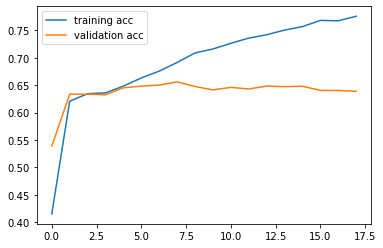

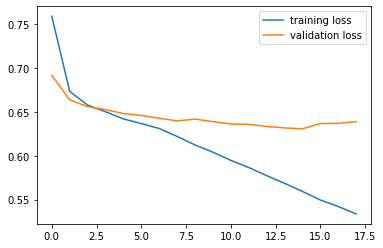

In [27]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='model_no_dropout_train_2022_task2', # test* is in gitignore, for testing without uploading
          model_fun=model_no_dropout,
          optimizer=opt_Adam,
          BATCH_SIZE=256,
          EPOCHS=100,
          STEPS_PER_EPOCH = 100,
          early_stopping=True,
          max_len = 100,
          #embedding_dim = 50,
          #max_words = 10000
         )

### *Model B*

In [7]:
#Reducing the learning rate
opt_Adam2 = Adam(clipnorm=1.5,learning_rate=0.0001)

In [8]:
def model_lower_hidden(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    
    """
    
    This model is the same as model_no_dropout, with the exception that we have doubled the number of hidden units.
    
    """
    
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(100, dropout=0.2))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc',f1_m], optimizer = optimizer)

    return model

Found 400000 word vectors.
Loaded 400000 word vectors.
(5001, 50)
Epoch 1/100
100/100 - 11s - loss: 0.7497 - acc: 0.3831 - f1_m: 0.0000e+00 - val_loss: 0.7314 - val_acc: 0.3897 - val_f1_m: 0.0000e+00
Epoch 2/100
100/100 - 5s - loss: 0.7256 - acc: 0.3854 - f1_m: 0.0000e+00 - val_loss: 0.7226 - val_acc: 0.3900 - val_f1_m: 0.0000e+00
Epoch 3/100
100/100 - 5s - loss: 0.7190 - acc: 0.3839 - f1_m: 0.0000e+00 - val_loss: 0.7163 - val_acc: 0.3888 - val_f1_m: 0.0000e+00
Epoch 4/100
100/100 - 5s - loss: 0.7139 - acc: 0.3806 - f1_m: 0.0000e+00 - val_loss: 0.7108 - val_acc: 0.3887 - val_f1_m: 0.0000e+00
Epoch 5/100

Epoch 00005: saving model to /home/jovyan/examples/examples/tensorflow/project-2022-group-4/checkpoints/model_lower_hidden_train_2022_task2/cp-0005.ckpt
100/100 - 5s - loss: 0.7084 - acc: 0.3834 - f1_m: 0.0000e+00 - val_loss: 0.7057 - val_acc: 0.3902 - val_f1_m: 0.0087
Epoch 6/100
100/100 - 5s - loss: 0.7041 - acc: 0.3853 - f1_m: 0.0124 - val_loss: 0.7019 - val_acc: 0.4220 - val_f1_m: 

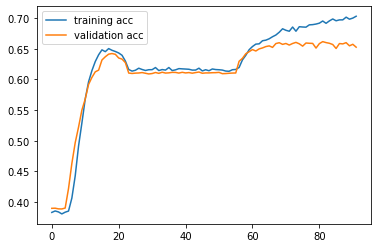

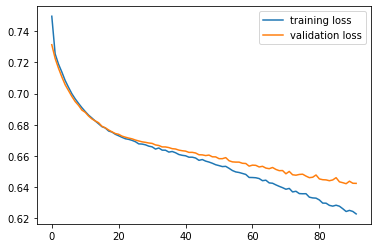

In [36]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='model_lower_hidden_train_2022_task2',
          model_fun=model_lower_hidden,
          optimizer=opt_Adam2,
          BATCH_SIZE=256,
          EPOCHS=100,
          STEPS_PER_EPOCH = 100,
          verbose = 2,
          max_len = 100,
          early_stopping = True,
          max_words = 5000
         )

### *Model C*

In [9]:
def model_double_hidden_fc(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    
    """
    
    This model is the same as model_lower_hidden but also includes an extra fully connected lower before the final layer.
    
    """
    
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(100, dropout=0.2))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    fc = Dense(500, activation='sigmoid')(merged)
    preds = Dense(1, activation='sigmoid')(fc)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc',f1_m], optimizer = optimizer)

    return model

Found 400000 word vectors.
Loaded 400000 word vectors.
(3001, 50)
Epoch 1/100
100/100 - 11s - loss: 0.6660 - acc: 0.6185 - f1_m: 0.7639 - val_loss: 0.6676 - val_acc: 0.6105 - val_f1_m: 0.7577
Epoch 2/100
100/100 - 5s - loss: 0.6649 - acc: 0.6126 - f1_m: 0.7593 - val_loss: 0.6634 - val_acc: 0.6110 - val_f1_m: 0.7581
Epoch 3/100
100/100 - 5s - loss: 0.6599 - acc: 0.6160 - f1_m: 0.7619 - val_loss: 0.6599 - val_acc: 0.6116 - val_f1_m: 0.7587
Epoch 4/100
100/100 - 5s - loss: 0.6553 - acc: 0.6173 - f1_m: 0.7630 - val_loss: 0.6576 - val_acc: 0.6104 - val_f1_m: 0.7576
Epoch 5/100

Epoch 00005: saving model to /home/jovyan/examples/examples/tensorflow/project-2022-group-4/checkpoints/model_double_hidden_fc_train_2022_task2/cp-0005.ckpt
100/100 - 5s - loss: 0.6524 - acc: 0.6145 - f1_m: 0.7609 - val_loss: 0.6535 - val_acc: 0.6107 - val_f1_m: 0.7580
Epoch 6/100
100/100 - 5s - loss: 0.6482 - acc: 0.6166 - f1_m: 0.7622 - val_loss: 0.6488 - val_acc: 0.6300 - val_f1_m: 0.7597
Epoch 7/100
100/100 - 5s 

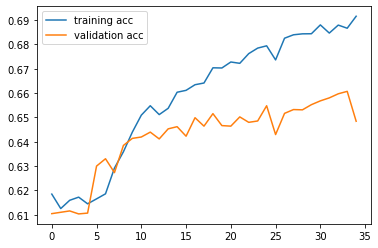

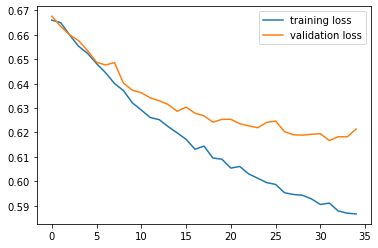

In [41]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='model_double_hidden_fc_train_2022_task2', # test* is in gitignore, for testing without uploading
          model_fun=model_double_hidden_fc,
          optimizer=opt_Adam2,
          BATCH_SIZE=256,
          EPOCHS=100,
          STEPS_PER_EPOCH = 100,
          verbose = 2,
          max_len = 100,
          early_stopping = True,
          max_words = 3000
         )

## 2. Evaluating models on 'Test' data

In [14]:
training_data = pd.read_csv(config.processed_datasets.get('train_2022_task2'))
testing_data = pd.read_csv(config.processed_datasets.get('valid_2022_task2'))

### *MODEL A*

In [15]:
#The tokenizer used should the same as that used on the training data for this specific model
tokenizer = get_tokenizer(training_data, max_words=10000)
embed_matrix = get_embed_matrix(tokenizer, embedding_dim=50)

#Creating datagenerator for the testing data with the specific tokenizer
testing_data_siamese = DataGeneratorSiamese(testing_data,
                                             tokenizer=tokenizer,
                                             max_len=100)
testing_data_siamese.on_epoch_end()

Found 400000 word vectors.
Loaded 400000 word vectors.
(10001, 50)


In [16]:
#Creating model equivalent to model A
modelA = model_no_dropout(max_len=100,tokenizer=tokenizer,embed_matrix=embed_matrix,embedding_dim=50, optimizer=opt_Adam)

#Loading saved model weights
checkpoint_path = config.checkpoints.get("dir") + 'model_no_dropout_train_2022_task2' + '/'
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
modelA.load_weights(latest)

#Evaluating testing data
modelA.evaluate(testing_data_siamese)

298/298 [==============================] - 5s 10ms/step - loss: 0.6227 - acc: 0.6542 - f1_m: 0.7169


[0.6270022392272949, 0.6477558612823486, 0.7109122276306152]

### *Model B*

In [17]:
#The tokenizer used should the same as that used on the training data for this specific model
tokenizer = get_tokenizer(training_data, max_words=5000)
embed_matrix = get_embed_matrix(tokenizer, embedding_dim=50)

#Creating datagenerator for the testing data with the specific tokenizer
testing_data_siamese = DataGeneratorSiamese(testing_data,
                                             tokenizer=tokenizer,
                                             max_len=100)
testing_data_siamese.on_epoch_end()

Found 400000 word vectors.
Loaded 400000 word vectors.
(5001, 50)


In [18]:
#Creating model equivalent to model A
modelB = model_lower_hidden(max_len=100,tokenizer=tokenizer,embed_matrix=embed_matrix,embedding_dim=50, optimizer=opt_Adam2)

#Loading saved model weights
checkpoint_path = config.checkpoints.get("dir") + 'model_lower_hidden_train_2022_task2' + '/'
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
modelB.load_weights(latest)

#Evaluating testing data
modelB.evaluate(testing_data_siamese)

298/298 [==============================] - 5s 10ms/step - loss: 0.6371 - acc: 0.6649 - f1_m: 0.7462


[0.6386151313781738, 0.6587668061256409, 0.738300085067749]

### *Model C*

In [19]:
#The tokenizer used should the same as that used on the training data for this specific model
tokenizer = get_tokenizer(training_data, max_words=3000)
embed_matrix = get_embed_matrix(tokenizer, embedding_dim=50)

#Creating datagenerator for the testing data with the specific tokenizer
testing_data_siamese = DataGeneratorSiamese(testing_data,
                                             tokenizer=tokenizer,
                                             max_len=100)
testing_data_siamese.on_epoch_end()

Found 400000 word vectors.
Loaded 400000 word vectors.
(3001, 50)


In [20]:
#Creating model equivalent to model C
modelC = model_double_hidden_fc(max_len=100,tokenizer=tokenizer,embed_matrix=embed_matrix,embedding_dim=50, optimizer=opt_Adam2)

#Loading saved model weights
checkpoint_path = config.checkpoints.get("dir") + 'model_double_hidden_fc_train_2022_task2' + '/'
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
modelC.load_weights(latest)

#Evaluating testing data
modelC.evaluate(testing_data_siamese)

298/298 [==============================] - 5s 10ms/step - loss: 0.6178 - acc: 0.6512 - f1_m: 0.7066


[0.613002359867096, 0.6527894139289856, 0.7045748829841614]